# Learning and Adaptivity, SS18

# Assignment 08 (24-June-2018)

##  Team Members:
- Debaraj Barua (9030412) 
- Md Zahiduzzaman (9030432)
- Ramit Sharma (9030410)


## Task A:

Using the python tools of your preference (TensorFlow, scikit-learn, numpy, pandas, etc).

1. Get the MNIST dataset, select one kind of model and train multiple instances of the same model in this dataset (say, from 1 to 100).

2. With the trained models, make ensembles of $[2, 3, ..., 100]$ members, evaluate the testing accuracy of each ensemble, and estimate the uncertainty of their outputs using a histogram or average of softmax outputs (depending on the model).

3. Does accuracy and uncertainty improve by having more members in each ensemble?


In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.misc import imshow

from IPython.display import display
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
training_data = mnist.train.images 
training_labels = mnist.train.labels
validation_data = mnist.validation.images 
validation_labels = mnist.validation.labels
test_data = mnist.test.images 
test_labels = mnist.test.labels

validation_data.shape

(5000, 784)

In [6]:
class EnsembleEvaluation:
    def __init__(self):
        self.training_data = mnist.train.images # Returns np.array
        self.training_labels = mnist.train.labels
        self.validation_data = mnist.validation.images # Returns np.array
        self.validation_labels = mnist.validation.labels
        self.test_data = mnist.test.images 
        self.test_labels = mnist.test.labels        
        self.clf = None        
       
        
    def train(self,n_estimators):
        self.clf = RandomForestClassifier(n_estimators = n_estimators)
        self.clf.fit(self.training_data, self.training_labels)
    
    def test(self):
        return self.clf.score(self.test_data, self.test_labels)
    
    def getUncertainity(self, random_img_idx):
        random_image = self.test_data[random_img_idx]
        random_image_label = self.test_labels[random_img_idx]
        uncertainity = self.clf.predict_proba(np.reshape(random_image, (1, -1)))
        
        return uncertainity

    def getIncorrectIndices(self):
        index_of_wrong_answers = []
        for i,data in enumerate(self.test_data):
            predicted_label = self.clf.predict(np.reshape(data, (1,784)))
            if predicted_label != self.test_labels[i]:
                index_of_wrong_answers.append(i)
        return index_of_wrong_answers

In [22]:
def plot_evaluations (accuracy_list,uncertainity_list):
    fig= plt.figure(1,figsize=(10, 8))
    plt.plot(np.arange(2,len(accuracy_list)+2), accuracy_list, label = 'Accuracy')
    plt.xlabel('Number of trees')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over multiple ensembles')
    plt.legend()
    plt.show()
    
    fig = plt.figure(2,figsize=(20, 8))
    ensemble_unc = [25,50,75,99]               
    for i,idx in enumerate(ensemble_unc):
        fig.add_subplot(2, 2, i+1)
        plt.bar( np.arange(0, 10, 1), np.squeeze(uncertainity_list[idx-2]))
        plt.xlabel('Classes')
        plt.ylabel('Prediction probability')
        plt.title('Uncertainity for one image for {} estimators:'.format(idx))
        plt.tight_layout()
        plt.xticks(np.arange(0, 10, 1))
    
    plt.legend()    
    plt.show()

In [8]:
filename_acc = 'accuracy_list.pkl'
filename_unc = 'uncertainty_list.pkl'
filename_class = 'ensemble_list.pkl'

In [11]:
import timeit

np.random.seed(10)
random_img_idx=np.random.randint(0,5000)
max_no_estimators = 100
accuracy_list = []
uncertainity_list=[]
ensemble_list = []


In [ ]:

start =timeit.default_timer()
for i in range (2,max_no_estimators+1):
    ens_eval = EnsembleEvaluation()
    ens_eval.train(i)
    ensemble_list.append(ens_eval)
    uncertainity_list.append(ens_eval.getUncertainity(random_img_idx))
    accuracy_list.append(ens_eval.test())
stop =timeit.default_timer()

print "Time: ",stop-start

In [ ]:
# Saving data

"""pickle.dump(accuracy_list, open(filename_acc, 'wb'))
print "dumped accuracy list"
pickle.dump(uncertainity_list, open(filename_unc, 'wb'))
print "dumped uncertainity_list"
"""

In [21]:
file = open(filename_acc,'rb')
accuracy_list = pickle.load(file)
file.close()

file = open(filename_unc,'rb')
uncertainity_list = pickle.load(file)
file.close()

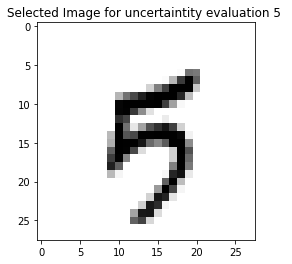

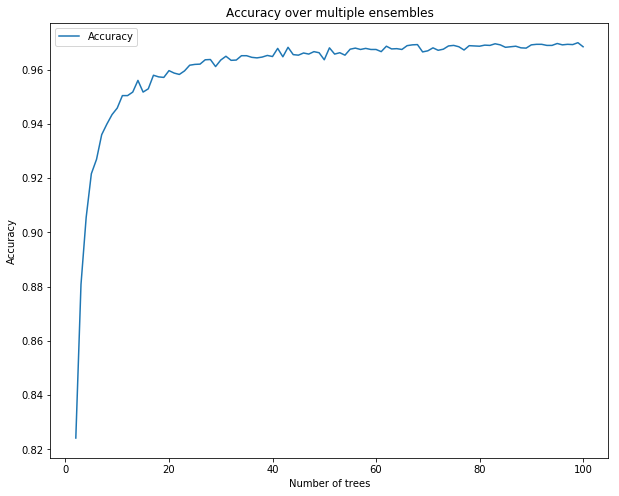

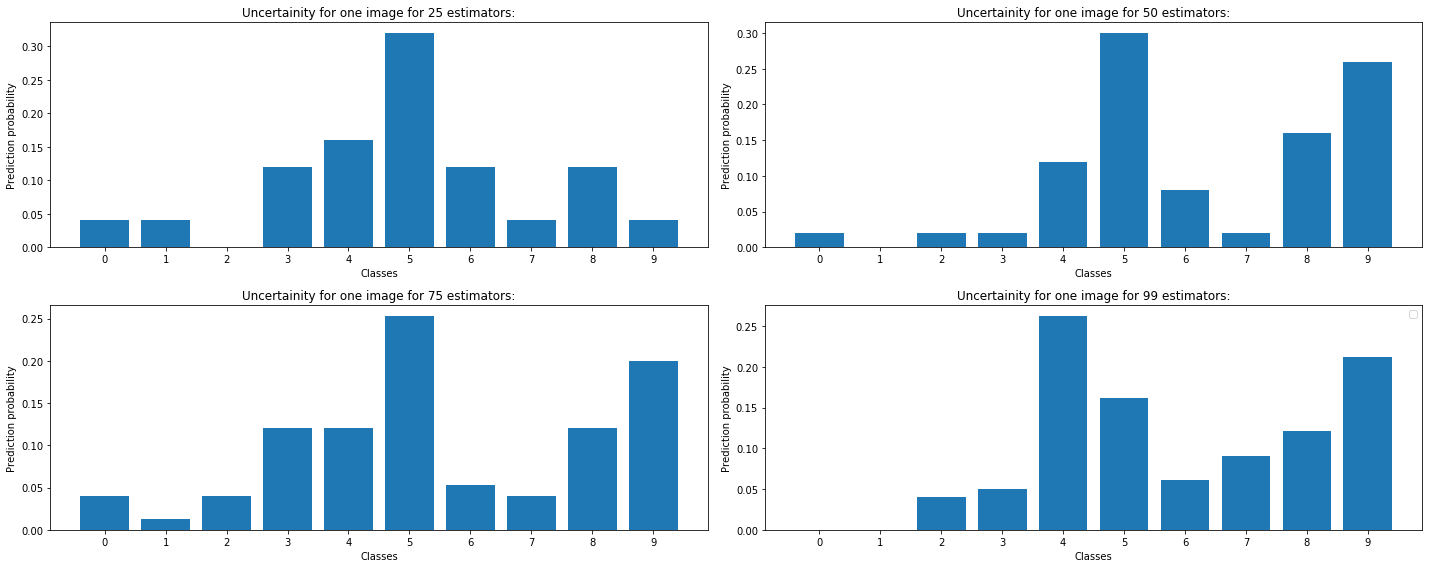

In [23]:
ens = EnsembleEvaluation()
image = ens.test_data[random_img_idx].reshape(1, -1)
label = ens.test_labels[random_img_idx]
plt.imshow(image.reshape(28, 28), cmap=plt.cm.binary)
plt.title("Selected Image for uncertaintity evaluation {} ".format(label))
plt.show()

plot_evaluations (accuracy_list,uncertainity_list)

From the above it is observed that the accuracy increases with the number of trees. However, the prediction probability does not seem to increase with more estimators.

Uncertainity, thus, seems to increase with more estimators.

---
## Task B:

4. Using a single ensemble of your choosing (you define the number of members), find the misclassified examples in the test set and analyze the uncertainty of those examples. Can the uncertainty explain why those examples are misclassified? Give examples and a complete analysis.


In [25]:
ens_eval = EnsembleEvaluation()
ens_eval.train(100)
acc=ens_eval.test()
incorrect_indices = ens_eval.getIncorrectIndices()
print (acc)

0.9698


In [30]:
incorrect_images = test_data[incorrect_indices,:]
incorrect_image_labels = test_labels[incorrect_indices]
#random_img_idx=np.random.randint(0,len(incorrect_indices),4)
random_img_idx=[133 170 108  52]

print "Number of incorrect image classification: ", len(incorrect_indices)
print "Random incorrect images selected:",random_img_idx

Number of incorrect image classification:  302
Random incorrect images selected: [133 170 108  52]


In [49]:
def plt_incorrect_image_details(classifier,image,label):
    prediction = classifier.predict(np.reshape(image, (1,-1)))
    uncertainity = classifier.predict_proba(np.reshape(image, (1,-1)))
    uncertainity = np.reshape(uncertainity,(10,-1))
    print ("correct label %i, predicted label %i" % (label,prediction))
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.bar(np.arange(0,10), uncertainity[:,0])
    plt.xticks(np.arange(0,10))
    plt.ylim(0,1)
    plt.xlim(-1,10,1)
    
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(image, (28,-1)))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    

correct label 8, predicted label 3


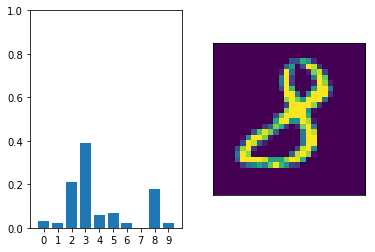


correct label 0, predicted label 6


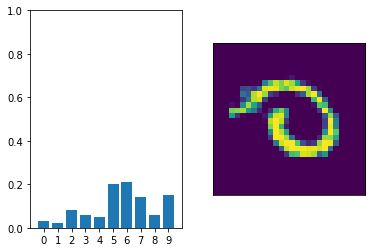


correct label 2, predicted label 0


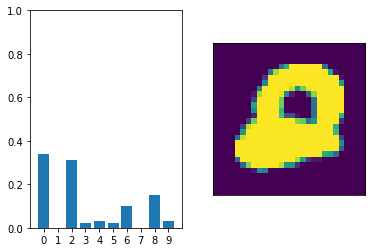


correct label 4, predicted label 9


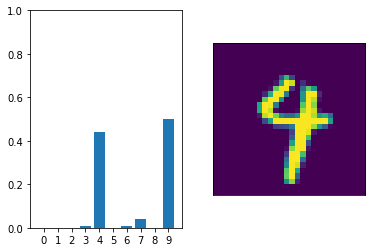

In [50]:
plt_incorrect_image_details(ens_eval.clf,incorrect_images[random_img_idx[0]],
                            incorrect_image_labels[random_img_idx[0]])
print ""
plt_incorrect_image_details(ens_eval.clf,incorrect_images[random_img_idx[1]],
                           incorrect_image_labels[random_img_idx[1]])
print ""
plt_incorrect_image_details(ens_eval.clf,incorrect_images[random_img_idx[2]],
                           incorrect_image_labels[random_img_idx[2]])
print ""
plt_incorrect_image_details(ens_eval.clf,incorrect_images[random_img_idx[3]],
                           incorrect_image_labels[random_img_idx[3]])

### Analysis:
- Class 8:
    - Predicted Label: 3
    - The probability of classification is low and is around 0.4. 
    - The misclassification may be attributed to the fact that the image is distorted and not clear enough for a correct 8. The top of the 8 is not completely closed.
    
- Class 0:
    - Predicted Label: 6
    - The probability of classification is low and is around 0.2. 
    - The image does not look like a zero, and resembles a 6 due to the gap.
- Class 2:
    - Predicted Label: 0
    - The probability of classification for 2 and 0 is very close, but 0 edges over 2.
    - This can be attributed to the fact that the image looks like a closed loop and resembles a zero.
    
- Class 4:
    - Predicted Label: 9
    - The probability of classification for 4 and 9 is very close, but 9 edges over 4.
    - The argument for this is similar to the earlier ones, the trailing line on the right is very small, thus resembling the number 9
        

---
## Task C:

5. Reproduce Figure one from the "_Simple and Scalable Predictive UncertaintyEstimation using Deep Ensembles_" paper (attached) using a random forest, computing regression uncertainty as the variance of the estimates across trees. The authors mention their metodology in _Section 3.2_, and one can easily reproduce the training set as its a sample of: $$y = x^3 + \text{noise}$$ where, noise is Gaussian with zero mean and $3^2$ variance, and $x$ is in the range $[-4, 4]$. The key idea of those figures is to show that uncertainty grows for values outside of the range $[-4, 4]$, more specifically, in the range $[-6, -4]$ and $[4, 6]$. To produce the figure, you can plot the mean and make confidence bands with size of square root of variance.Remember that I expect a good report of results, not just concentrating on the code, but also on scientific analysis of your results and explanations.

In [63]:
x =  np.linspace(-4,4,100,endpoint=True)
noise =  np.random.normal(loc=0.0, scale=3, size=100)
y = x**3+noise
training_data = np.reshape(x,(-1,1))
training_data = np.hstack((training_data,(np.reshape(y,(-1,1)))))
test_data = np.linspace(-6,6,80,endpoint=True)
test_data = np.reshape(test_data,(-1,1))


In [90]:
def train(no_trees):
    regressor = RandomForestRegressor(n_estimators = no_trees, random_state = 0)
    regressor.fit(training_data[:,0][np.newaxis].T, training_data[:,1])
    prediction = regressor.predict(test_data)
    prediction = np.squeeze(prediction)
    mean = []
    variance = []

    for data in test_data:
        interim_prediction_list = []
        for i in range(regressor.n_estimators):
            pred = regressor.estimators_[i].predict(np.reshape(data,(-1,1)))
            interim_prediction_list.append(pred)
        mean.append(np.mean(interim_prediction_list))
        variance.append(np.var(interim_prediction_list))

    std_dev = np.array(variance)**0.5
    
    print("The standard deviation is ", np.mean(std_dev))

    x = np.linspace(-6,6,200); y = x **3
    plt.plot(x,y, color = 'b',label="Ground Truth")
    plt.scatter(training_data[:,0], training_data[:,1], color = 'r', label="Training data with Noise")
    plt.scatter(test_data, prediction, color = 'g', label='Predictions')
    plt.fill_between(np.squeeze(test_data),mean, std_dev, color = 'grey', label="Uncertainity")
    plt.legend()
    plt.show()
    return std_dev

For 2 esimators: 
('The standard deviation is ', 1.0417673532471927)


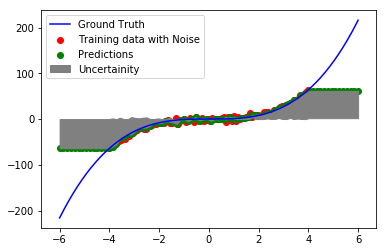

For 50 esimators: 
('The standard deviation is ', 2.4511954118884627)


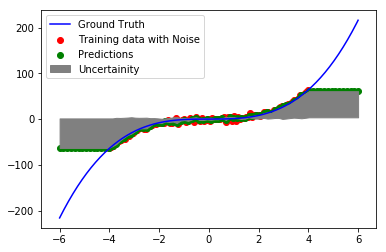

For 99 esimators: 
('The standard deviation is ', 2.6668128301049703)


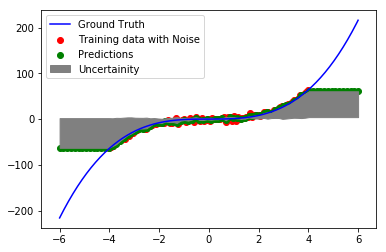

In [91]:
print "For 2 esimators: "
std_dev2=train(2)
print "For 50 esimators: "
std_dev50=train(50)
print "For 99 esimators: "
std_dev99=train(99)

Text(0.5,1,'Mean Stanard deviance against number of estimators')

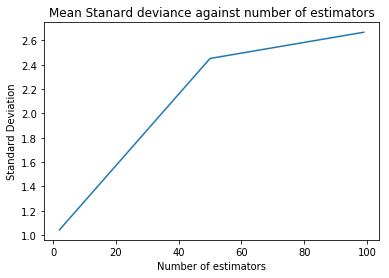

In [92]:
mean_std_dev = [np.mean(std_dev2),np.mean(std_dev50),np.mean(std_dev99)]

plt.plot([2,50,99], mean_std_dev)
plt.xlabel('Number of estimators')
plt.ylabel('Standard Deviation')
plt.title("Mean Stanard deviance against number of estimators")


### Analysis:
From the first set of graphs it is observed that the uncertainity increases for unseen data in the range of  $[-6, -4]$ and $[4, 6]$. This can be observed by the grey shaded area in the graphs. This can be explained as in case of in unseen data the regressor estimates the lowest value observed in the range $[-6, -4]$ and the highest value in the range of $[4, 6]$; as the nature of the distribution cannot be extrapolated from the given data in these regions. 

Since the confidence of the predicted value is low, the uncertainity can be observed as the shaded region between 0 and the lowest/highest values respectively.

In addition, it is observed that the mean standard deviation increases with the number of estimators. This can be intuitively understood as for more estimators  we will have a wider range of deviations.

